# Mini-Project
This is the main mini-project notebook handeling pre-processing, model definition, training, and evalutaion. 

### Imports
The first cell block handels some necessary imports.

In [52]:
# Import Generic dataset proceessing class.
from generic_dataset_new import GenericDataset

In [53]:
ds = GenericDataset(863, splits=(0.5, 0.3, 0.2), show_info=False)

In [54]:
print(ds)

--- Maternal Health Risk Dataset Info ---
uci_id: 863
name: Maternal Health Risk
repository_url: https://archive.ics.uci.edu/dataset/863/maternal+health+risk
data_url: https://archive.ics.uci.edu/static/public/863/data.csv
abstract: Data has been collected from different hospitals, community clinics, maternal health cares from the rural areas of Bangladesh through the IoT based risk monitoring system.
area: Health and Medicine
tasks: ['Classification']
characteristics: ['Multivariate']
num_instances: 1013
num_features: 6
feature_types: ['Real', 'Integer']
demographics: ['Age']
target_col: ['RiskLevel']
index_col: None
has_missing_values: no
missing_values_symbol: None
year_of_dataset_creation: 2020
last_updated: Fri Nov 03 2023
dataset_doi: 10.24432/C5DP5D
creators: ['Marzia Ahmed']
num_classes: 3
-----------------------------------------


In [55]:
import som
(X_train, L_train) = ds.get_train()
L_train = list(L_train)

(X_test, L_test) = ds.get_test()
L_test = list(L_test)

print(X_train.shape,len(L_train))
print(X_test.shape,len(L_test))


(506, 6) 506
(203, 6) 203


100%|██████████| 100/100 [00:03<00:00, 29.09it/s]


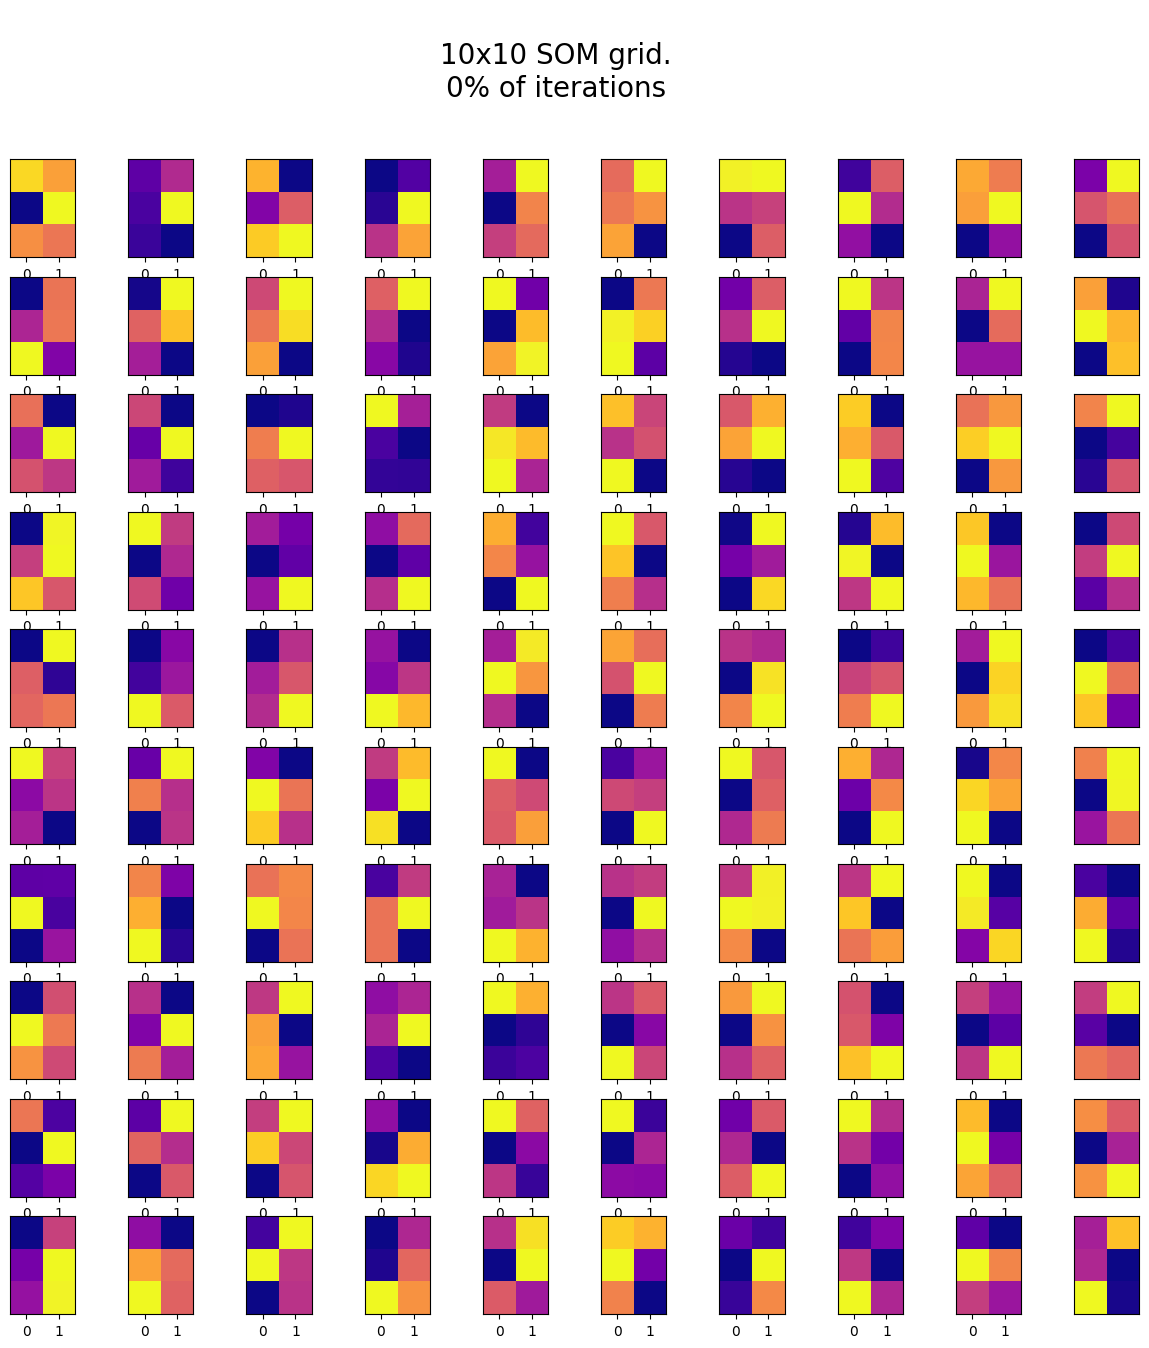

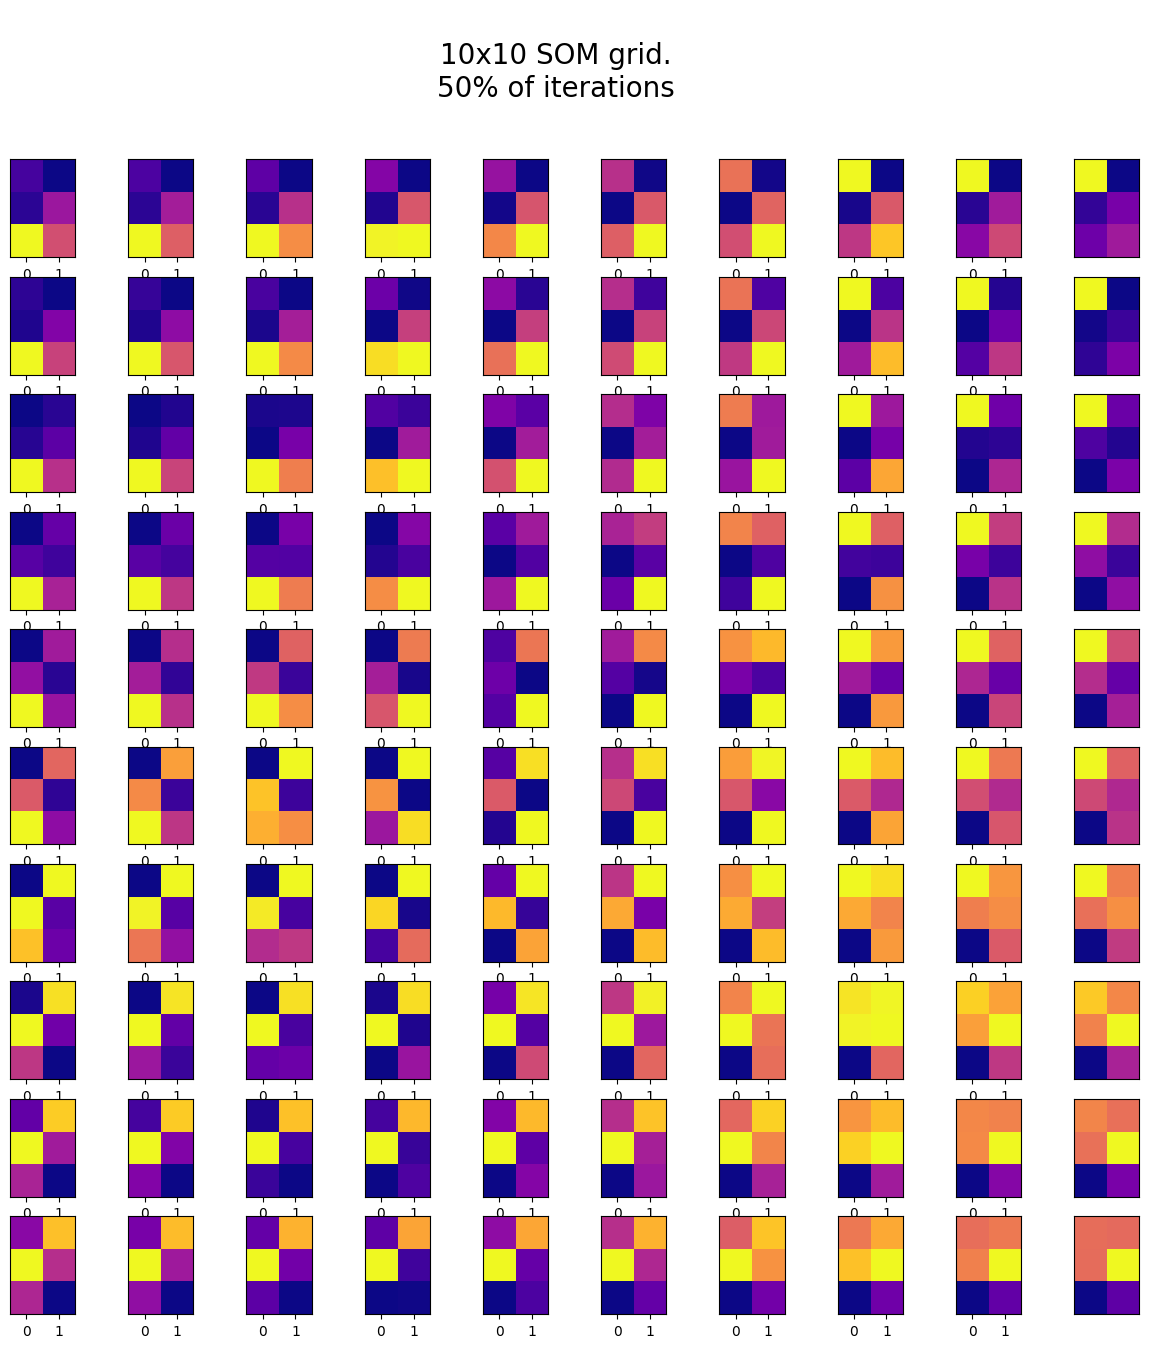

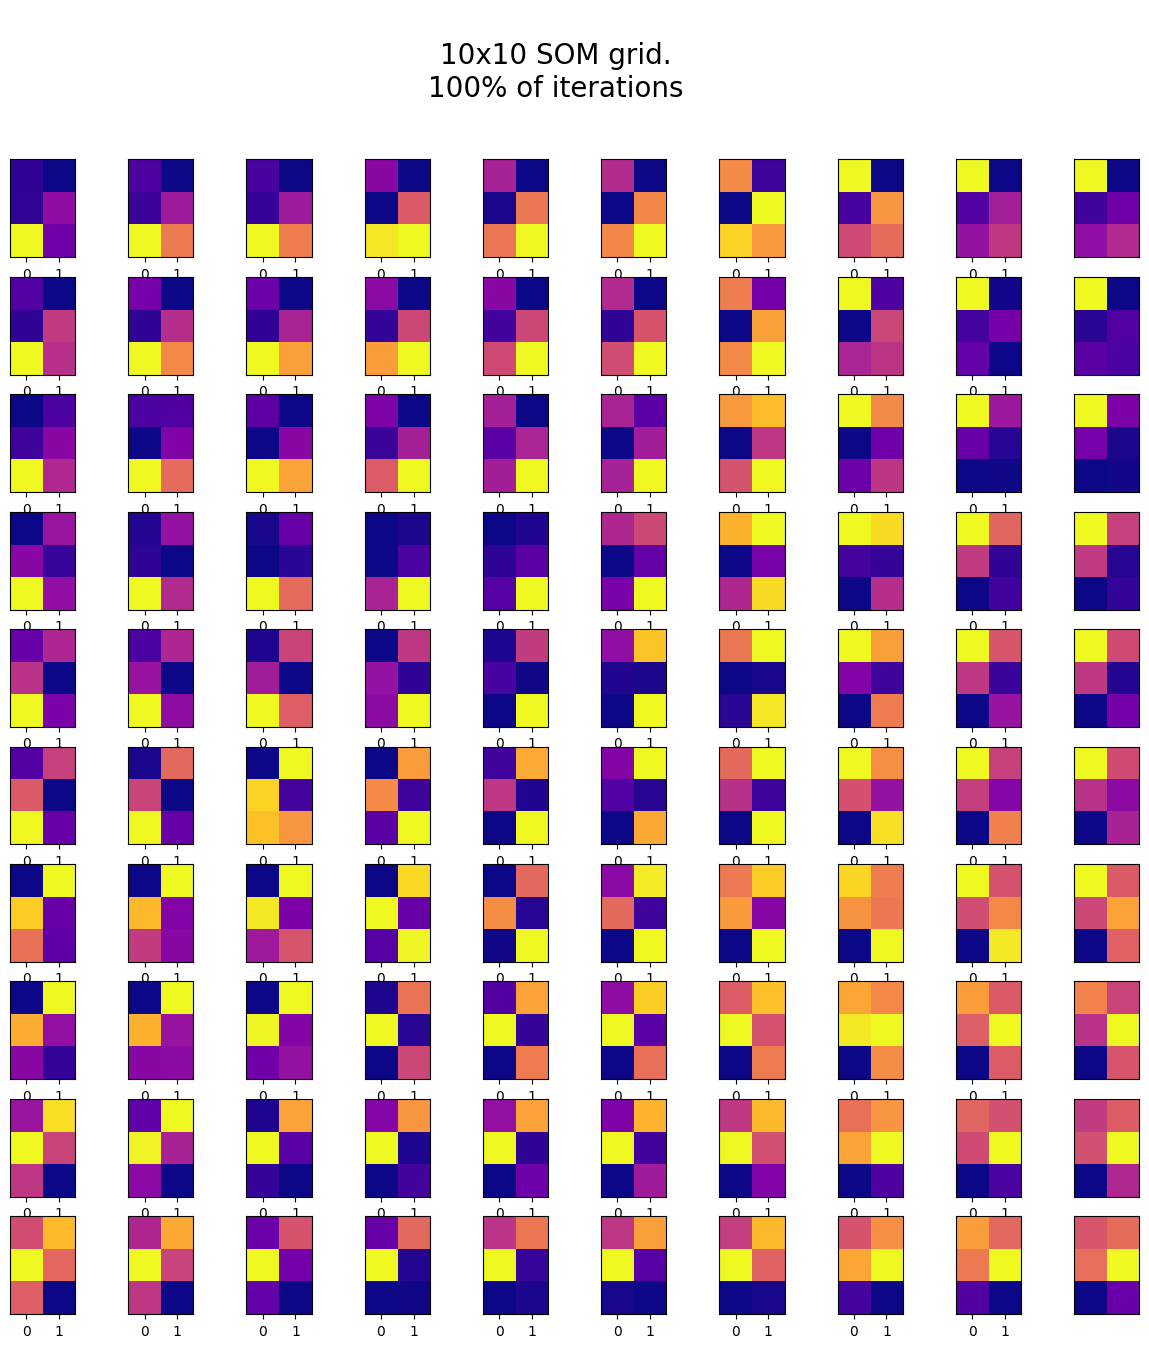

In [56]:
trained_som = som.SOM(X_train,nepochs=100,showMode=1,dispRes=[3,2],ndim=10)


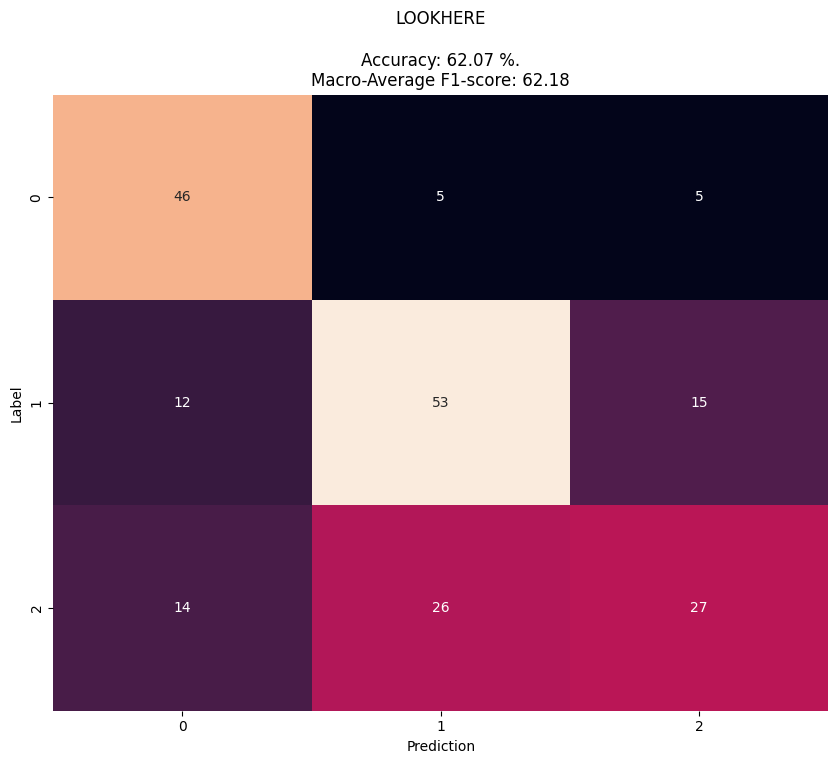

In [57]:
grid, conf = som.SOM_Test(trained_som,X_train,L_train,X_test,L_test,ds.get_metadata()["num_classes"],ndim=10)
som.display_conf(conf=conf,classes=[0,1,2],text="LOOKHERE")

In [58]:
import numpy as np
(np.sum(np.eye(conf.shape[0])*conf)/np.sum(conf)).item()

0.6206896551724138

In [59]:
a = ds.get_test()
print(a)

(array([[-0.53176305, -0.80453983, -0.88348938, -0.43963228, -0.50041619,
        -0.68852063],
       [-0.53176305, -1.36233213, -1.24846362, -0.57569258, -0.50041619,
         0.30175044],
       [-0.45504101,  0.86883707, -0.51851513, -0.54167751, -0.50041619,
        -0.68852063],
       ...,
       [-0.9153732 ,  0.31104477,  0.21143336, -0.60970766,  2.3411079 ,
         0.16028314],
       [ 0.23545727,  1.42662937,  1.67133033, -0.54167751, -0.50041619,
         0.44321774],
       [ 1.23284368,  0.31104477,  0.21143336, -0.54167751,  3.05148892,
        -0.68852063]]), array([1, 2, 2, 2, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 2, 2, 2, 1, 0, 1, 1,
       1, 2, 0, 0, 2, 1, 1, 2, 0, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 0, 2, 1,
       0, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 2, 0, 2, 1, 2, 2, 0, 1, 2,
       0, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 1, 0, 0, 2, 1, 2, 2, 1,
       1, 2, 0, 1, 1, 2, 2, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 2, 2,
       2, 1, 1, 0, 1, 2, 2, 0, 1, 2, 1, 1, 2, 1, 2

In [60]:
a[0]

array([[-0.53176305, -0.80453983, -0.88348938, -0.43963228, -0.50041619,
        -0.68852063],
       [-0.53176305, -1.36233213, -1.24846362, -0.57569258, -0.50041619,
         0.30175044],
       [-0.45504101,  0.86883707, -0.51851513, -0.54167751, -0.50041619,
        -0.68852063],
       ...,
       [-0.9153732 ,  0.31104477,  0.21143336, -0.60970766,  2.3411079 ,
         0.16028314],
       [ 0.23545727,  1.42662937,  1.67133033, -0.54167751, -0.50041619,
         0.44321774],
       [ 1.23284368,  0.31104477,  0.21143336, -0.54167751,  3.05148892,
        -0.68852063]])

In [61]:
from sklearn import svm
import numpy as np
(X,Y) = ds.get_train()
clf = svm.SVC(kernel='poly')
clf.fit(X,Y)
(X_test,Y_test) = ds.get_test()
Y_pred = clf.predict(X_test)
print(Y_test,Y_pred,Y_pred==Y_test)
print("Accuracy:",(sum(Y_pred==Y_test)/Y_test.shape)[0])


[1 2 2 2 0 1 1 2 0 0 1 0 0 1 1 2 2 2 1 0 1 1 1 2 0 0 2 1 1 2 0 1 2 1 1 0 1
 2 1 2 1 0 2 1 0 2 0 2 0 1 1 1 2 2 2 1 1 2 0 2 1 2 2 0 1 2 0 2 1 1 1 0 1 1
 0 1 2 2 0 1 1 0 0 2 1 2 2 1 1 2 0 1 1 2 2 0 2 2 0 0 0 1 0 1 1 1 0 1 2 2 2
 1 1 0 1 2 2 0 1 2 1 1 2 1 2 2 0 2 1 2 1 0 0 1 0 2 0 0 0 1 2 1 1 1 1 2 2 2
 2 1 0 2 1 2 2 0 0 1 2 0 0 0 2 1 2 2 1 2 1 1 2 1 1 0 1 1 1 0 0 1 2 0 1 0 0
 0 2 1 1 2 0 0 1 2 0 0 1 2 1 1 2 0 1] [1 1 1 1 1 1 1 1 0 0 2 0 0 1 1 1 1 1 1 0 2 1 1 2 0 1 1 1 1 1 2 1 0 1 1 0 2
 1 1 1 1 0 1 1 1 1 0 2 0 0 1 1 1 2 1 2 1 2 1 2 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 2 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1
 1 1 0 1 1 2 0 1 1 1 1 2 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 0 0 2 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0
 0 1 1 1 2 0 0 1 1 0 0 1 1 1 1 2 0 2] [ True False False False False  True  True False  True  True False  True
  True  True  True False False False  True  True False  True  True  True
  True False False  True  Tr

In [62]:
import som
def run_som_on_ds(ds,ndim,nepochs):
    (X_train, L_train) = ds.get_train()
    L_train = list(L_train)

    (X_test, L_test) = ds.get_test()
    L_test = list(L_test)

    trained_som = som.SOM(X_train,nepochs=nepochs,ndim=ndim)

    _, conf = som.SOM_Test(trained_som,X_train,L_train,X_test,L_test,ds.get_metadata()["num_classes"],ndim=ndim)
    accuracy = (np.sum(np.eye(conf.shape[0])*conf)/np.sum(conf)).item()
    return accuracy

In [63]:
def run_svm_on_ds(ds,clf):
    (X,Y) = ds.get_train()
    
    clf.fit(X,Y)
    (X_test,Y_test) = ds.get_test()
    Y_pred = clf.predict(X_test)
    return (sum(Y_pred.squeeze()==Y_test.squeeze())/Y_test.squeeze().shape)[0]

In [64]:
dataset_ids = [53,45,186,27,17,519,109,174,545,19,697,1,73,144,544,336,292,94,15,14,856,42,267]
dataset_ids = [53,863,850,46,27,17,519,109,174,545,19,697,59,73,144,544,336,292,94,15,14,529,267]
print(len(dataset_ids))
print()
sum_accuracy_SVM = 0
sum_accuracy_SOM = 0
for id in dataset_ids:
    print("id:",id)
    ds = GenericDataset(id, splits=(0.5, 0.3, 0.2), show_info=False)
    print("name:",ds.get_metadata()['name'])
    print("num_instances:",ds.get_metadata()['num_instances'])
    accuracy = run_svm_on_ds(ds,svm.SVC(kernel='rbf'))
    sum_accuracy_SVM += accuracy
    print("accuracy SVM:",str(round(accuracy*1000)/10) + "%")
    accuracy = run_som_on_ds(ds,ndim=16,nepochs=20)
    sum_accuracy_SOM += accuracy
    print("accuracy SOM:",str(round(accuracy*1000)/10) + "%")
    print()

avg_accuracy_SVM = sum_accuracy_SVM/len(dataset_ids)
avg_accuracy_SOM = sum_accuracy_SOM/len(dataset_ids)
print("\n"*3)
print("Average accuracy SVM:", str(round(avg_accuracy_SVM*1000)/10)+"%")
print("Average accuracy SOM:", str(round(avg_accuracy_SOM*1000)/10)+"%")

23

id: 53
name: Iris
num_instances: 150
accuracy SVM: 73.3%


100%|██████████| 20/20 [00:00<00:00, 218.99it/s]

accuracy SOM: 66.7%

id: 863


name: Maternal Health Risk
num_instances: 1013
accuracy SVM: 68.5%


100%|██████████| 20/20 [00:00<00:00, 24.16it/s]


accuracy SOM: 43.3%

id: 850
name: Raisin
num_instances: 900
accuracy SVM: 85.6%


100%|██████████| 20/20 [00:00<00:00, 34.37it/s]


accuracy SOM: 76.1%

id: 46
name: Hepatitis
num_instances: 155
accuracy SVM: 93.8%


100%|██████████| 20/20 [00:00<00:00, 253.66it/s]

accuracy SOM: 37.5%

id: 27


name: Credit Approval
num_instances: 690
accuracy SVM: 84.3%


100%|██████████| 20/20 [00:01<00:00, 19.31it/s]


accuracy SOM: 68.7%

id: 17
name: Breast Cancer Wisconsin (Diagnostic)
num_instances: 569
accuracy SVM: 98.2%


100%|██████████| 20/20 [00:00<00:00, 28.98it/s]


accuracy SOM: 87.7%

id: 519
name: Heart Failure Clinical Records
num_instances: 299
accuracy SVM: 80.0%


100%|██████████| 20/20 [00:00<00:00, 83.29it/s]


accuracy SOM: 76.7%

id: 109
name: Wine
num_instances: 178
accuracy SVM: 100.0%


100%|██████████| 20/20 [00:00<00:00, 130.45it/s]

accuracy SOM: 75.0%

id: 174


name: Parkinsons
num_instances: 197
accuracy SVM: 82.1%


100%|██████████| 20/20 [00:00<00:00, 114.34it/s]

accuracy SOM: 43.6%

id: 545


name: Rice (Cammeo and Osmancik)
num_instances: 3810
accuracy SVM: 92.7%


100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


accuracy SOM: 90.4%

id: 19
name: Car Evaluation
num_instances: 1728
accuracy SVM: 90.5%


100%|██████████| 20/20 [00:01<00:00, 10.55it/s]


accuracy SOM: 66.8%

id: 697
name: Predict Students' Dropout and Academic Success
num_instances: 4424
accuracy SVM: 75.1%


100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


accuracy SOM: 65.5%

id: 59
name: Letter Recognition
num_instances: 20000
accuracy SVM: 93.4%


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


accuracy SOM: 13.8%

id: 73
name: Mushroom
num_instances: 8124
accuracy SVM: 100.0%


100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


accuracy SOM: 97.5%

id: 144
name: Statlog (German Credit Data)
num_instances: 1000
accuracy SVM: 78.0%


100%|██████████| 20/20 [00:01<00:00, 11.18it/s]


accuracy SOM: 56.0%

id: 544
name: Estimation of Obesity Levels Based On Eating Habits and Physical Condition 
num_instances: 2111
accuracy SVM: 88.9%


100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


accuracy SOM: 34.8%

id: 336
name: Chronic Kidney Disease
num_instances: 400
accuracy SVM: 100.0%


100%|██████████| 20/20 [00:00<00:00, 78.68it/s]


accuracy SOM: 90.2%

id: 292
name: Wholesale customers
num_instances: 440
accuracy SVM: 65.9%


100%|██████████| 20/20 [00:00<00:00, 69.85it/s]


accuracy SOM: 54.5%

id: 94
name: Spambase
num_instances: 4601
accuracy SVM: 93.5%


100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


accuracy SOM: 86.8%

id: 15
name: Breast Cancer Wisconsin (Original)
num_instances: 699
accuracy SVM: 97.1%


100%|██████████| 20/20 [00:00<00:00, 44.16it/s]


accuracy SOM: 90.5%

id: 14
name: Breast Cancer
num_instances: 286
accuracy SVM: 70.7%


100%|██████████| 20/20 [00:00<00:00, 54.80it/s]


accuracy SOM: 65.5%

id: 529
name: Early Stage Diabetes Risk Prediction
num_instances: 520
accuracy SVM: 98.1%


100%|██████████| 20/20 [00:00<00:00, 34.87it/s]


accuracy SOM: 85.6%

id: 267
name: Banknote Authentication
num_instances: 1372
accuracy SVM: 99.6%


100%|██████████| 20/20 [00:00<00:00, 27.91it/s]

accuracy SOM: 77.1%





Average accuracy SVM: 87.4%
Average accuracy SOM: 67.4%
